Load the LLM, in this case we are using gpt2

In [ ]:
#!pip install transformers

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [2]:
#!pip install --upgrade pillow

In [3]:
import sys
sys.path.append("../")

In [4]:
#!pip install ssl

In [5]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [6]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
guiding_wfa = get_man_woman_wfa(wrapper.terminal_symbol)

In [7]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [8]:
guiding_generator.generate_words(10)

[ϵ,
 The,man,studied,engineering,
 The,woman,
 The,man,studied,medicine,
 The,
 The,
 The,
 The,man,studied,maths,
 ϵ,
 The]

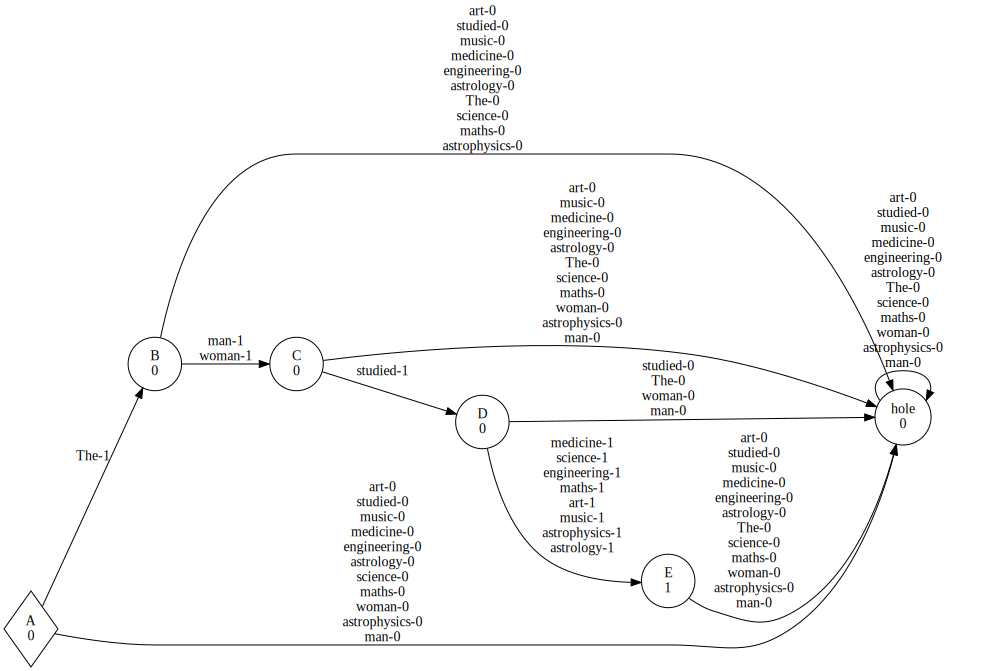

In [9]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [10]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
property_model = get_man_woman_wfa(wrapper.terminal_symbol)
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True)

In [11]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [12]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [13]:
learning_result = learner.learn(teacher, verbose=True)

C:\Users\franz\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:1003: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


Size before update: 6
CE: The,woman,studied
----update_node----
Old Node (new Leaf) The,man
New Leaf The,woman
dict_keys([The,man,studied,astrology, ϵ, art, The, The,man, The,man,studied, The,woman,studied])
dict_keys([The,man,studied,astrology, ϵ, art, The, The,man, The,man,studied, The,woman,studied, The,woman])
--------
Size after update: 8


In [14]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied"), SymbolStr("music")])
#teacher.next_token_probabilities(test_seq)

In [15]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [16]:
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
generator = UniformLengthSequenceGenerator(alphabet, 100)


In [19]:
import numpy as np
res = list()
words = generator.generate_all_words()
for word in words:
    probs = list(next_token_probabilities(syncrhronic_model, word).values())
    if np.sum(probs) > 0:
        print(word, probs)
        res.append((word, probs))
    if len(res)>1000:
        break

ϵ [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8150554362001219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18494456379987814]
The,man [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
The,woman [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
The,man,studied [0.0, 0.0, 0.10310200487330855, 0.000513365324027957, 0.015094676083658535, 0.28290055939742004, 0.0, 0.038663325036608964, 0.3542335998756149, 0.044667891596331534, 0.1608245778130295, 0.0, 0.0]
The,woman,studied [0.0, 0.0, 0.11580939670236158, 0.0003051264044383362, 0.010473400768920641, 0.11403830394617974, 0.0, 0.013286574497955702, 0.5334909267777668, 0.0436594976371076, 0.16893677326526965, 0.0, 0.0]


KeyboardInterrupt: 

In [ ]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
the_man_studied = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied")])
the_woman_studied = Sequence([SymbolStr("The"),SymbolStr("woman"),SymbolStr("studied")])

In [ ]:
man = next_token_probabilities(syncrhronic_model, the_man_studied).values()
woman = next_token_probabilities(syncrhronic_model, the_woman_studied).values()

In [ ]:
next_token_probabilities(syncrhronic_model, the_woman_studied)

In [ ]:
wrapper_res = next_token_probabilities(wrapper, the_woman_studied).values()

In [ ]:
partitioner.get_partition(woman)

In [ ]:
partitioner.get_partition(man)

In [ ]:
partitioner.are_in_same_partition(wrapper_res, woman)

In [ ]:
partitioner.are_in_same_partition(A, B)

In [ ]:
next_token_probabilities(wrapper, test_seq)

In [ ]:
next_token_probabilities(guiding_wfa, test_seq)

In [ ]:
next_token_probabilities(syncrhronic_model, test_seq)

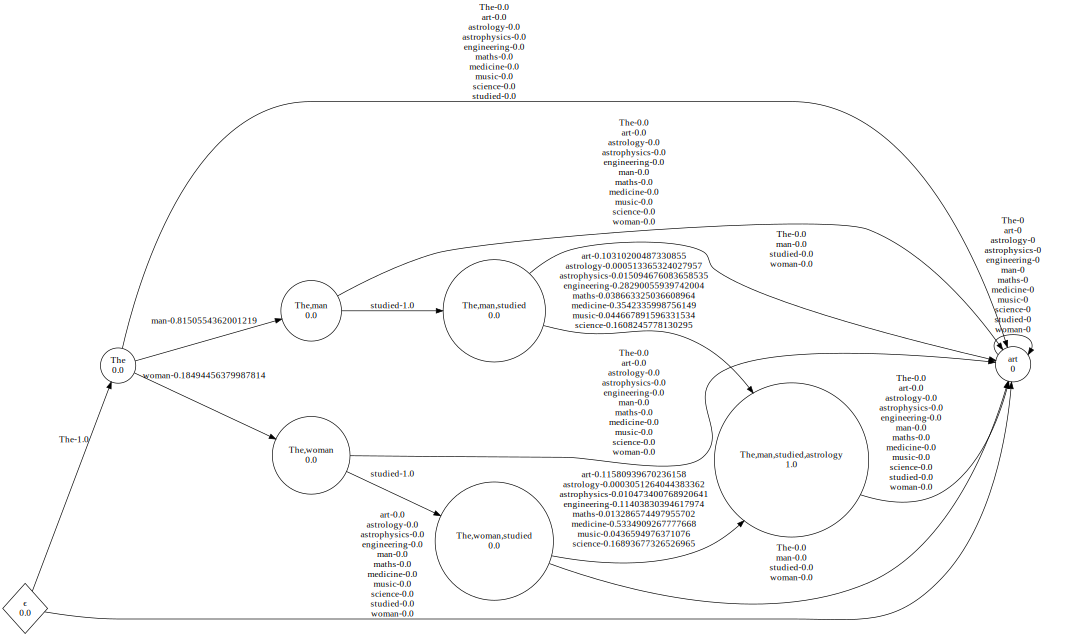

In [17]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)